In [130]:
from typing import Optional

import matplotlib.pyplot as plt
import polars as pl

In [131]:
pl.show_versions()

--------Version info---------
Polars:              1.6.0
Index type:          UInt32
Platform:            Windows-10-10.0.19045-SP0
Python:              3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:24:51) [MSC v.1940 64 bit (AMD64)]

----Optional dependencies----
adbc_driver_manager  <not installed>
altair               5.4.1
cloudpickle          <not installed>
connectorx           <not installed>
deltalake            <not installed>
fastexcel            <not installed>
fsspec               <not installed>
gevent               <not installed>
great_tables         <not installed>
matplotlib           3.9.2
nest_asyncio         1.6.0
numpy                2.1.1
openpyxl             <not installed>
pandas               2.2.2
pyarrow              17.0.0
pydantic             <not installed>
pyiceberg            <not installed>
sqlalchemy           <not installed>
torch                <not installed>
xlsx2csv             <not installed>
xlsxwriter           <not installed>


# Helper Functions

In [132]:
def cohen_d(xs: pl.Series, ys: pl.Series):
    from math import sqrt

    mean_x, mean_y = xs.mean(), ys.mean()
    assert isinstance(mean_x, float)
    assert isinstance(mean_y, float)

    var_x, var_y = xs.var(), ys.var()
    assert isinstance(var_x, float)
    assert isinstance(var_y, float)

    n_x, n_y = len(xs), len(ys)
    return (mean_x - mean_y) / sqrt(((n_x - 1) * var_x + (n_y - 1) * var_y) / (n_x + n_y - 2))

# Random Bytes

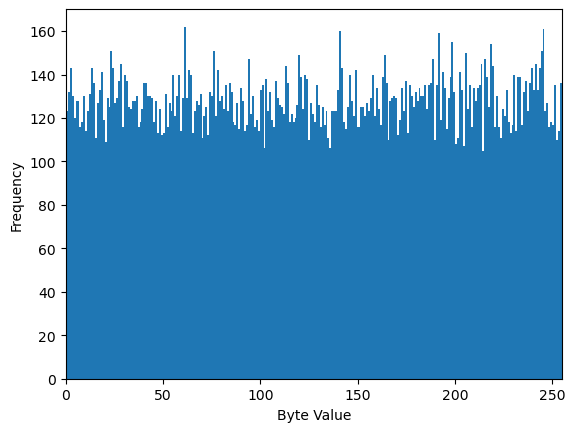

In [133]:
with open('random.bin', 'rb') as f:
    random = f.read()

pl.Series(random).cast(pl.UInt8).to_pandas().plot(kind='hist', bins=256, xlim=(0, 255), xlabel='Byte Value')

pass  # suppress output

# Data Loader

In [134]:
def read_csv(path: str):
    return pl.scan_csv(path, has_header=False).rename({'column_1': 'ms'}).collect()['ms']


KIND = 'hist'
BINS = 200
XLABEL = 'Milliseconds'
XLIM = 0, 2
ALPHA = 0.6
LEGEND = True


class Data:
    runtime: str
    raw_for_loop: pl.Series
    for_of_loop: pl.Series
    array_method: pl.Series
    generator: pl.Series

    def __init__(self, runtime: str, prefix: str) -> None:
        self.runtime = runtime
        self.raw_for_loop = read_csv(f'{prefix}/raw-for-loop.csv')
        self.for_of_loop = read_csv(f'{prefix}/for-of-loop.csv')
        self.array_method = read_csv(f'{prefix}/array-method.csv')
        self.generator = read_csv(f'{prefix}/generator.csv')

    def plot_raw_for_loop(self, title: Optional[str], label: str = 'raw-for-loop', color: str = 'blue'):
        self.raw_for_loop.to_pandas().plot(
            kind=KIND,
            title=title,
            legend=LEGEND,
            bins=BINS,
            xlim=XLIM,
            xlabel=XLABEL,
            label=label,
            color=color,
            edgecolor=color,
            alpha=ALPHA,
        )

    def plot_for_of_loop(self, title: Optional[str], label: str = 'for-of-loop', color: str = 'orange'):
        self.for_of_loop.to_pandas().plot(
            kind=KIND,
            title=title,
            legend=LEGEND,
            bins=BINS,
            xlim=XLIM,
            xlabel=XLABEL,
            label=label,
            color=color,
            edgecolor=color,
            alpha=ALPHA,
        )

    def plot_array_method(self, title: Optional[str], label: str = 'array-method', color: str = 'green'):
        self.array_method.to_pandas().plot(
            kind=KIND,
            title=title,
            legend=LEGEND,
            bins=BINS,
            xlim=XLIM,
            xlabel=XLABEL,
            label=label,
            color=color,
            edgecolor=color,
            alpha=ALPHA,
        )

    def plot_generator(self, title: Optional[str], label: str = 'generator', color: str = 'red'):
        self.generator.to_pandas().plot(
            kind=KIND,
            title=title,
            legend=LEGEND,
            bins=BINS,
            xlim=XLIM,
            xlabel=XLABEL,
            label=label,
            color=color,
            edgecolor=color,
            alpha=ALPHA,
        )

    def plot_all(self):
        self.plot_raw_for_loop(self.runtime)
        self.plot_for_of_loop(self.runtime)
        self.plot_array_method(self.runtime)
        self.plot_generator(self.runtime)

    def print_raw_for_loop_stats(self):
        mean = self.raw_for_loop.mean()
        mode = self.raw_for_loop.mode().mean()
        std = self.raw_for_loop.std()
        print(f'{self.runtime} raw-for-loop:', f'mean={mean}', f'mode={mode}', f'std={std}')

    def print_for_of_loop_stats(self):
        mean = self.for_of_loop.mean()
        mode = self.for_of_loop.mode().mean()
        std = self.for_of_loop.std()
        print(f'{self.runtime} for-of-loop:', f'mean={mean}', f'mode={mode}', f'std={std}')

    def print_array_method_stats(self):
        mean = self.array_method.mean()
        mode = self.array_method.mode().mean()
        std = self.array_method.std()
        print(f'{self.runtime} array-method:', f'mean={mean}', f'mode={mode}', f'std={std}')

    def print_generator_stats(self):
        mean = self.generator.mean()
        mode = self.generator.mode().mean()
        std = self.generator.std()
        print(f'{self.runtime} generator:', f'mean={mean}', f'mode={mode}', f'std={std}')

    def print_all_stats(self):
        self.print_raw_for_loop_stats()
        self.print_for_of_loop_stats()
        self.print_array_method_stats()
        self.print_generator_stats()

    def print_cohen_versus_baseline(self):
        print(f'{self.runtime} raw-for-loop versus for-of-loop:', cohen_d(self.raw_for_loop, self.for_of_loop))
        print(f'{self.runtime} raw-for-loop versus array-method:', cohen_d(self.raw_for_loop, self.array_method))
        print(f'{self.runtime} raw-for-loop versus generator:', cohen_d(self.raw_for_loop, self.generator))

In [135]:
# Loading all the data
node = Data('Node.js', 'node')
deno = Data('Deno', 'deno')
bun = Data('Bun', 'bun')

# Node.js v22.8.0

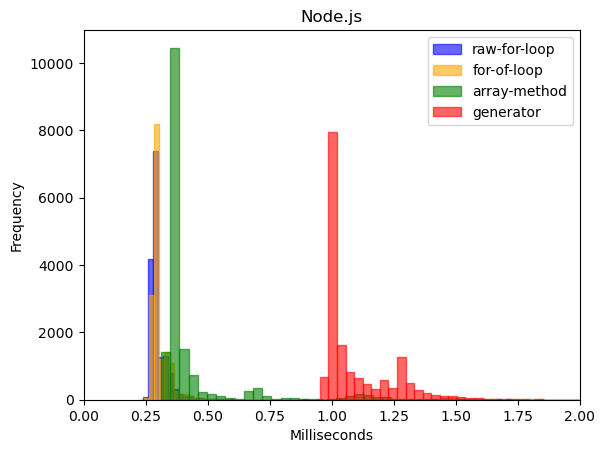

In [136]:
node.plot_all()

In [137]:
node.print_all_stats()

Node.js raw-for-loop: mean=0.33090382080078096 mode=0.282799999999952 std=0.19754229553837294
Node.js for-of-loop: mean=0.3368336059570307 mode=0.28729999999995925 std=0.20307622835319442
Node.js array-method: mean=0.436028387451172 mode=0.35570000000006985 std=0.24040091364507674
Node.js generator: mean=1.102369921874991 mode=1.0010000000002037 std=0.21340645676020156


In [138]:
node.print_cohen_versus_baseline()

Node.js raw-for-loop versus for-of-loop: -0.029600326227973827
Node.js raw-for-loop versus array-method: -0.4778005445345434
Node.js raw-for-loop versus generator: -3.7517666136473795


# Deno 1.46.3

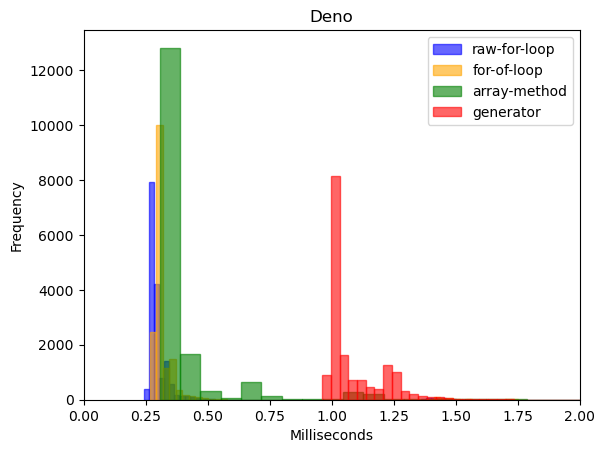

In [139]:
deno.plot_all()

In [140]:
deno.print_all_stats()

Deno raw-for-loop: mean=0.32670593261719144 mode=0.282799999999952 std=0.1856855334012125
Deno for-of-loop: mean=0.3439844970703103 mode=0.2962999999999738 std=0.19873516781286757
Deno array-method: mean=0.4221017639160154 mode=0.34619999999995343 std=0.3948847781729021
Deno generator: mean=1.0946259460449386 mode=1.018000000000029 std=0.1843454212626283


In [141]:
deno.print_cohen_versus_baseline()

Deno raw-for-loop versus for-of-loop: -0.08984228760931505
Deno raw-for-loop versus array-method: -0.3091690253338442
Deno raw-for-loop versus generator: -4.150544529985308


# Node.js + Deno: One and the Same

"Eyeball statistics" are sufficient in seeing that the Node.js and Deno results are one and the same.

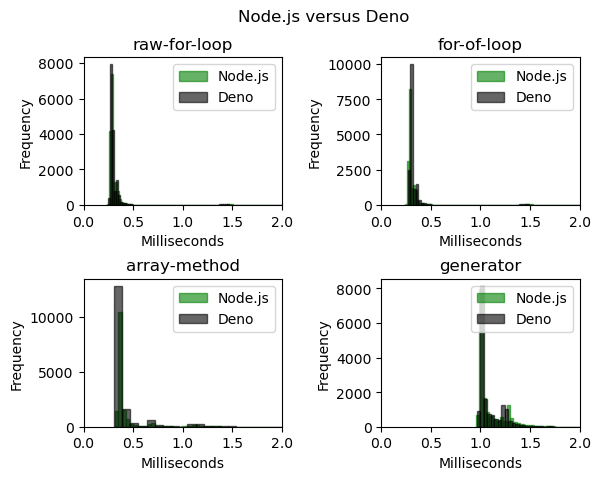

In [142]:
plt.suptitle('Node.js versus Deno')
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2, 2, 1)
node.plot_raw_for_loop('raw-for-loop', label=node.runtime, color='green')
deno.plot_raw_for_loop('raw-for-loop', label=deno.runtime, color='black')

plt.subplot(2, 2, 2)
node.plot_for_of_loop('for-of-loop', label=node.runtime, color='green')
deno.plot_for_of_loop('for-of-loop', label=deno.runtime, color='black')

plt.subplot(2, 2, 3)
node.plot_array_method('array-method', label=node.runtime, color='green')
deno.plot_array_method('array-method', label=deno.runtime, color='black')

plt.subplot(2, 2, 4)
node.plot_generator('generator', label=node.runtime, color='green')
deno.plot_generator('generator', label=deno.runtime, color='black')

In [143]:
print('Node.js versus Deno raw-for-loop:', cohen_d(node.raw_for_loop, deno.raw_for_loop))
print('Node.js versus Deno for-of-loop:', cohen_d(node.for_of_loop, deno.for_of_loop))
print('Node.js versus Deno array-method:', cohen_d(node.array_method, deno.array_method))
print('Node.js versus Deno generator:', cohen_d(node.generator, deno.generator))

Node.js versus Deno raw-for-loop: 0.021897576988315456
Node.js versus Deno for-of-loop: -0.03559119472568116
Node.js versus Deno array-method: 0.04260215401757211
Node.js versus Deno generator: 0.03883520889832218


None of the effect sizes show significant improvements. However, if a conclusion must be drawn: Deno performs better than Node.js up to a very small effect.

# Bun 1.1.26

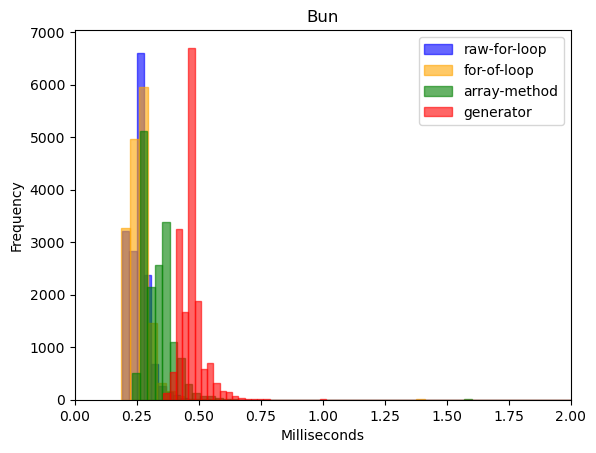

In [144]:
bun.plot_all()

In [145]:
bun.print_all_stats()

Bun raw-for-loop: mean=0.2785661804199214 mode=0.2626000000000204 std=0.274920299694637
Bun for-of-loop: mean=0.2789021850585911 mode=0.2644000000000233 std=0.2718324017113159
Bun array-method: mean=0.36083227539062346 mode=0.27070000000003347 std=0.32735701107401477
Bun generator: mean=0.4918631652832044 mode=0.47119999999995343 std=0.26508748550780814


In [146]:
bun.print_cohen_versus_baseline()

Bun raw-for-loop versus for-of-loop: -0.0012290722267517171
Bun raw-for-loop versus array-method: -0.27215390730196776
Bun raw-for-loop versus generator: -0.7898465157478102
